In [1]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates



import numpy as np
import pandas as pd
import copy

from tslib.src import tsUtils
from tslib.src.synthcontrol.syntheticControl import RobustSyntheticControl
from tslib.tests import testdata

In [2]:


filename = r'..\tests\testdata\BrazilFires.csv'


df = pd.read_csv(filename, index_col='YR')
allColumns = df.columns.values    

In [3]:
pd.set_option('display.max_columns', 10)
df.head()

,AC_FIRES,AL_FIRES,AM_FIRES,BA_FIRES,CE_FIRES,...,RI_FIRES,RO_FIRES,SA_FIRES,SE_FIRES,TO_FIRES
YR,,,,,,,,,,,
2004,3160,159,5765,10423,4780,...,3437,14878,5819,190,12202
2005,9427,217,8051,16410,4672,...,2297,25718,3606,200,10885
2006,1456,161,5451,7589,3280,...,2501,7175,4064,147,6429
2007,1419,128,3403,20471,4329,...,2067,15886,3107,124,15974
2008,2808,277,3502,17600,4617,...,1217,7841,1740,243,4915


In [4]:
states = df.columns.values.tolist()
StateKey = 'AM_FIRES'


states.remove(StateKey)
otherStates = states



p = 1.0

In [5]:
trainDF=df.head(11)
trainDF.reset_index(drop=True, inplace=True)
trainDF

,AC_FIRES,AL_FIRES,AM_FIRES,BA_FIRES,CE_FIRES,...,RI_FIRES,RO_FIRES,SA_FIRES,SE_FIRES,TO_FIRES
0,3160,159,5765,10423,4780,...,3437,14878,5819,190,12202
1,9427,217,8051,16410,4672,...,2297,25718,3606,200,10885
2,1456,161,5451,7589,3280,...,2501,7175,4064,147,6429
3,1419,128,3403,20471,4329,...,2067,15886,3107,124,15974
4,2808,277,3502,17600,4617,...,1217,7841,1740,243,4915
5,2095,325,10042,5092,4567,...,2778,5783,2495,206,5749
6,4684,222,9547,15512,3738,...,2437,13315,6168,143,25069
7,1912,232,5288,13061,3773,...,2567,5623,4499,173,10387
8,3180,352,9848,17378,4040,...,2219,7422,3159,231,5294
9,3242,208,6093,7217,2898,...,1617,4656,3101,185,8127


In [6]:
testDF=df.tail(3)
testDF.reset_index(drop=True, inplace=True)
testDF

,AC_FIRES,AL_FIRES,AM_FIRES,BA_FIRES,CE_FIRES,...,RI_FIRES,RO_FIRES,SA_FIRES,SE_FIRES,TO_FIRES
0,5512,590,16536,18397,3420,...,2553,16472,2907,299,9123
1,6993,400,14676,6751,3245,...,4539,15223,5581,152,14854
2,7042,159,16263,8249,2555,...,4271,12062,7760,75,21129


Text(0.5,1,'Singular Value Spectrum')

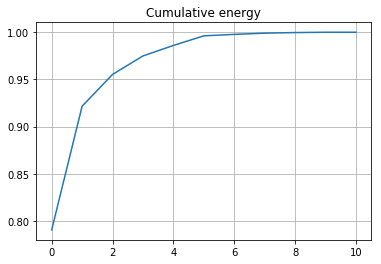

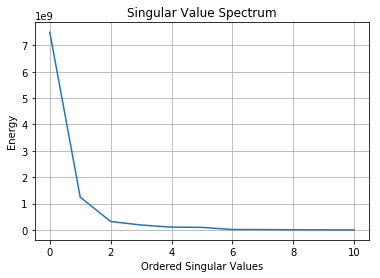

In [7]:
(U, s, Vh) = np.linalg.svd((trainDF) - np.mean(trainDF))
s2 = np.power(s, 2)
spectrum = np.cumsum(s2)/np.sum(s2)

plt.plot(spectrum)
plt.grid()
plt.title("Cumulative energy")
plt.figure()
plt.plot(s2)
plt.grid()


plt.xlabel("Ordered Singular Values") 
plt.ylabel("Energy")


plt.title("Singular Value Spectrum")


In [8]:
len(trainDF)

11

In [15]:
singvals = 6
rscModel = RobustSyntheticControl(StateKey, singvals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
rscModel.fit(trainDF)
denoisedDF = rscModel.model.denoisedDF()

In [16]:
predictions = []
predictions = np.dot(testDF[otherStates], rscModel.model.weights)
actual = df[[StateKey]]
actual.reset_index(inplace=True)
years=actual['YR'].astype(str).tolist()
trainingYears=years[0:11]
testYears=years[11:14]

model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)

actual=actual.reset_index(drop=True)


In [17]:
testYears

['2015', '2016', '2017']

In [18]:
rscModel.model.weights

array([ 0.26494435,  0.02317334, -0.0098751 ,  0.06981547,  0.00225515,
        0.00784452,  0.10719027, -0.10713591, -0.37949492,  0.22990737,
        0.01357819,  0.79381124,  0.09716656, -0.12092876,  0.12439117,
        0.00885964,  0.09881415])

In [19]:
otherStates

['AC_FIRES',
 'AL_FIRES',
 'BA_FIRES',
 'CE_FIRES',
 'DI_FIRES',
 'ES_FIRES',
 'GO_FIRES',
 'MA_FIRES',
 'MI_FIRES',
 'PA_FIRES',
 'PE_FIRES',
 'PI_FIRES',
 'RI_FIRES',
 'RO_FIRES',
 'SA_FIRES',
 'SE_FIRES',
 'TO_FIRES']

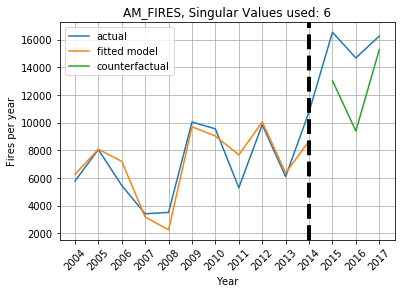

In [20]:
fig, ax = plt.subplots(1,1)
tick_spacing = 1
# this is a bug in matplotlib
label_markings = np.insert(years[::tick_spacing], 0, 'dummy')

ax.set_xticks(np.arange(len(label_markings)))
ax.set_xticklabels(label_markings, rotation=45)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

plt.plot(years, actual[StateKey] ,label='actual')
plt.xlabel('Year')
plt.ylabel('Fires per year')

plt.plot(trainingYears, model_fit, label='fitted model')
plt.plot(testYears, predictions, label='counterfactual')
plt.title(StateKey+', Singular Values used: '+str(singvals))

yearTrainEnd='2014'
xposition = pd.to_datetime(yearTrainEnd,  errors='coerce')
plt.axvline(x=str(yearTrainEnd), color='k', linestyle='--', linewidth=4)
plt.grid()
plt.legend()